In [50]:
import numpy as np
from glob import glob
import os
import gc
from pathlib import Path
import yaml

from matplotlib import pyplot as plt
# from cycler import cycler
from matplotlib.backends.backend_pdf import PdfPages
plt.style.use('clarke-default')

from scipy.optimize import curve_fit
from scipy import stats
from scipy.interpolate import RegularGridInterpolator

# plt.rcParams.update({'figure.dpi': 150})
# plt.rcParams.update({'axes.prop_cycle': cycler(color=['#5994cd', '#d74164', '#4eaa76', '#d88300', '#7365cf', \
#                                                       '#c85e3e', '#83a23e', '#c851b1', '#1850a1'])})

from iminuit import Minuit
from iminuit.cost import LeastSquares

from importlib import reload
import data_processing as dp

from signal_models import gas_collision_spectrum

In [85]:
# drive_path = '/Users/clarke/Data'
drive_path = '/Volumes/LaCie/'

sphere_date = '20260215'
data_type = 'xenon'

base_path = f'{drive_path}/gas_collisions/pulse_calibration/sphere_{sphere_date}/'

if not os.path.exists(drive_path):
    print('Error: check that the external drive is plugged in!')

config_dirs = glob(f'configs/sphere_{sphere_date}/*')

[print(i) for i in config_dirs]
print()

config_ind = -1

with open(config_dirs[config_ind] + '/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

config['calibrate'] = False

template = np.array(config['template'])
resolution = config['resolution']

for key in config.keys():
    print(key + ':\t ', config[key])

configs/sphere_20260215/20260216_p6e_6e-8mbar_d137khz_0
configs/sphere_20260215/20260219_p6e_4e-8mbar_d137khz_0

apply_notch:	  False
calibrate:	  False
d_sphere_nm:	  100.0
f_cutoff:	  [25000.0, 100000.0]
fit_window:	  0.1
keV_per_N:	  3.1897882840718262e+19
meters_per_volt:	  2.6780049680555713e-07
resolution:	  54.52830966438975
search_window:	  5e-05
template:	  [-0.03554688564731502, -0.023924201008772506, -0.0006534584155965829, 0.027461580682985966, 0.04845874144177789, 0.050062969749404156, 0.02635605448817303, -0.01758880273759195, -0.06546955754055497, -0.09453073721084795, -0.08327786841043466, -0.020658260005773678, 0.08545057127996025, 0.20391976216843943, 0.28577199486376714, 0.2805575898383637, 0.15827685834958768, -0.07279142682848296, -0.35828755014771335, -0.6028845546018576, -0.6922507056026566, -0.5374822325337766, -0.13422514832203425, 0.39752168660973114, 0.8404509058379309, 0.9857199902753451, 0.7585276295682597, 0.2677162286864329, -0.2624424884121697, -0.623151

In [86]:
base_path = f'{drive_path}/gas_collisions/{data_type}_data/sphere_{sphere_date}/'

folders = glob(base_path + '*')

bkg_datasets = {}

for folder in folders:
    print(folder.split(base_path)[-1])
    all_items = glob(folder + '/*')
    subfolders = np.unique(['_'.join(s.split('_')[:-1]) for s in all_items])
    sub_datasets = []
    for subfolder in subfolders:
        sub_datasets.append(subfolder.split(base_path)[-1].split('/')[-1])
        print('\t' + subfolder.split(base_path)[-1].split('/')[-1])
    bkg_datasets[folder.split(base_path)[-1]] = sub_datasets

20260219_p6e_1e-7mbar
	20260219_dfg
20260219_p6e_1e-6mbar
	20260219_dfg
20260219_p6e_1e-7mbar_1
	20260219_dfg
20260219_p6e_2e-7mbar
	20260219_dfg
20260219_p6e_4e-7mbar
	20260219_dfg
20260219_p6e_4e-7mbar_1
	20260219_dfg
20260219_p6e_5e-8mbar
	20260219_dfg
20260219_p6e_7e-7mbar
20260219_p6e_7e-8mbar
	20260219_dfg
20260219_p6e_8e-7mbar
	20260219_dfg


In [87]:
ds_paths = glob('/Users/clarke/Code/nanospheres/processed' + base_path.split(drive_path)[-1] + '/*')
base_path_bkg = f'{drive_path}/gas_collisions/background_data/sphere_{sphere_date}/'
ds_paths.append(glob('/Users/clarke/Code/nanospheres/processed' + base_path_bkg.split(drive_path)[-1] + '/*')[0])
print([p.split('/')[-1] for p in ds_paths])

['20260219_p6e_4e-7mbar_1', '20260219_p6e_1e-6mbar', '20260219_p6e_1e-7mbar_1', '20260219_p6e_8e-7mbar', '20260219_p6e_7e-8mbar', '20260219_p6e_2e-7mbar', '20260219_p6e_3e-8mbar_xevalveclosed']


In [88]:
datasets = []

for ds_path in ds_paths:
    processed_path = glob(ds_path + '/*')[0]
    nd = dp.NanoDataset()
    nd.load_from_hdf5(processed_path)
    datasets.append(nd)

datasets = list(np.array(datasets)[np.argsort([np.mean(nd.pressures) for nd in datasets])])

Dataset 1: P=6.8e-08 mbar (CCG), fit P=1.09e-08, T=302+/-11 K, alpha=1.00, valid=True
Dataset 2: P=1.0e-07 mbar (CCG), fit P=2.04e-08, T=287+/-7 K, alpha=1.00, valid=True
Dataset 3: P=2.2e-07 mbar (CCG), fit P=4.77e-08, T=299+/-4 K, alpha=1.00, valid=True
Dataset 4: P=4.1e-07 mbar (CCG), fit P=1.31e-07, T=221+/-4 K, alpha=1.00, valid=True
Dataset 5: P=7.3e-07 mbar (CCG), fit P=1.50e-07, T=314+/-2 K, alpha=1.00, valid=True
Dataset 6: P=1.4e-06 mbar (CCG), fit P=3.41e-07, T=288+/-2 K, alpha=1.00, valid=True

Fit temperatures:
  Dataset 1: T = 302 K
  Dataset 2: T = 287 K
  Dataset 3: T = 299 K
  Dataset 4: T = 221 K
  Dataset 5: T = 314 K
  Dataset 6: T = 288 K


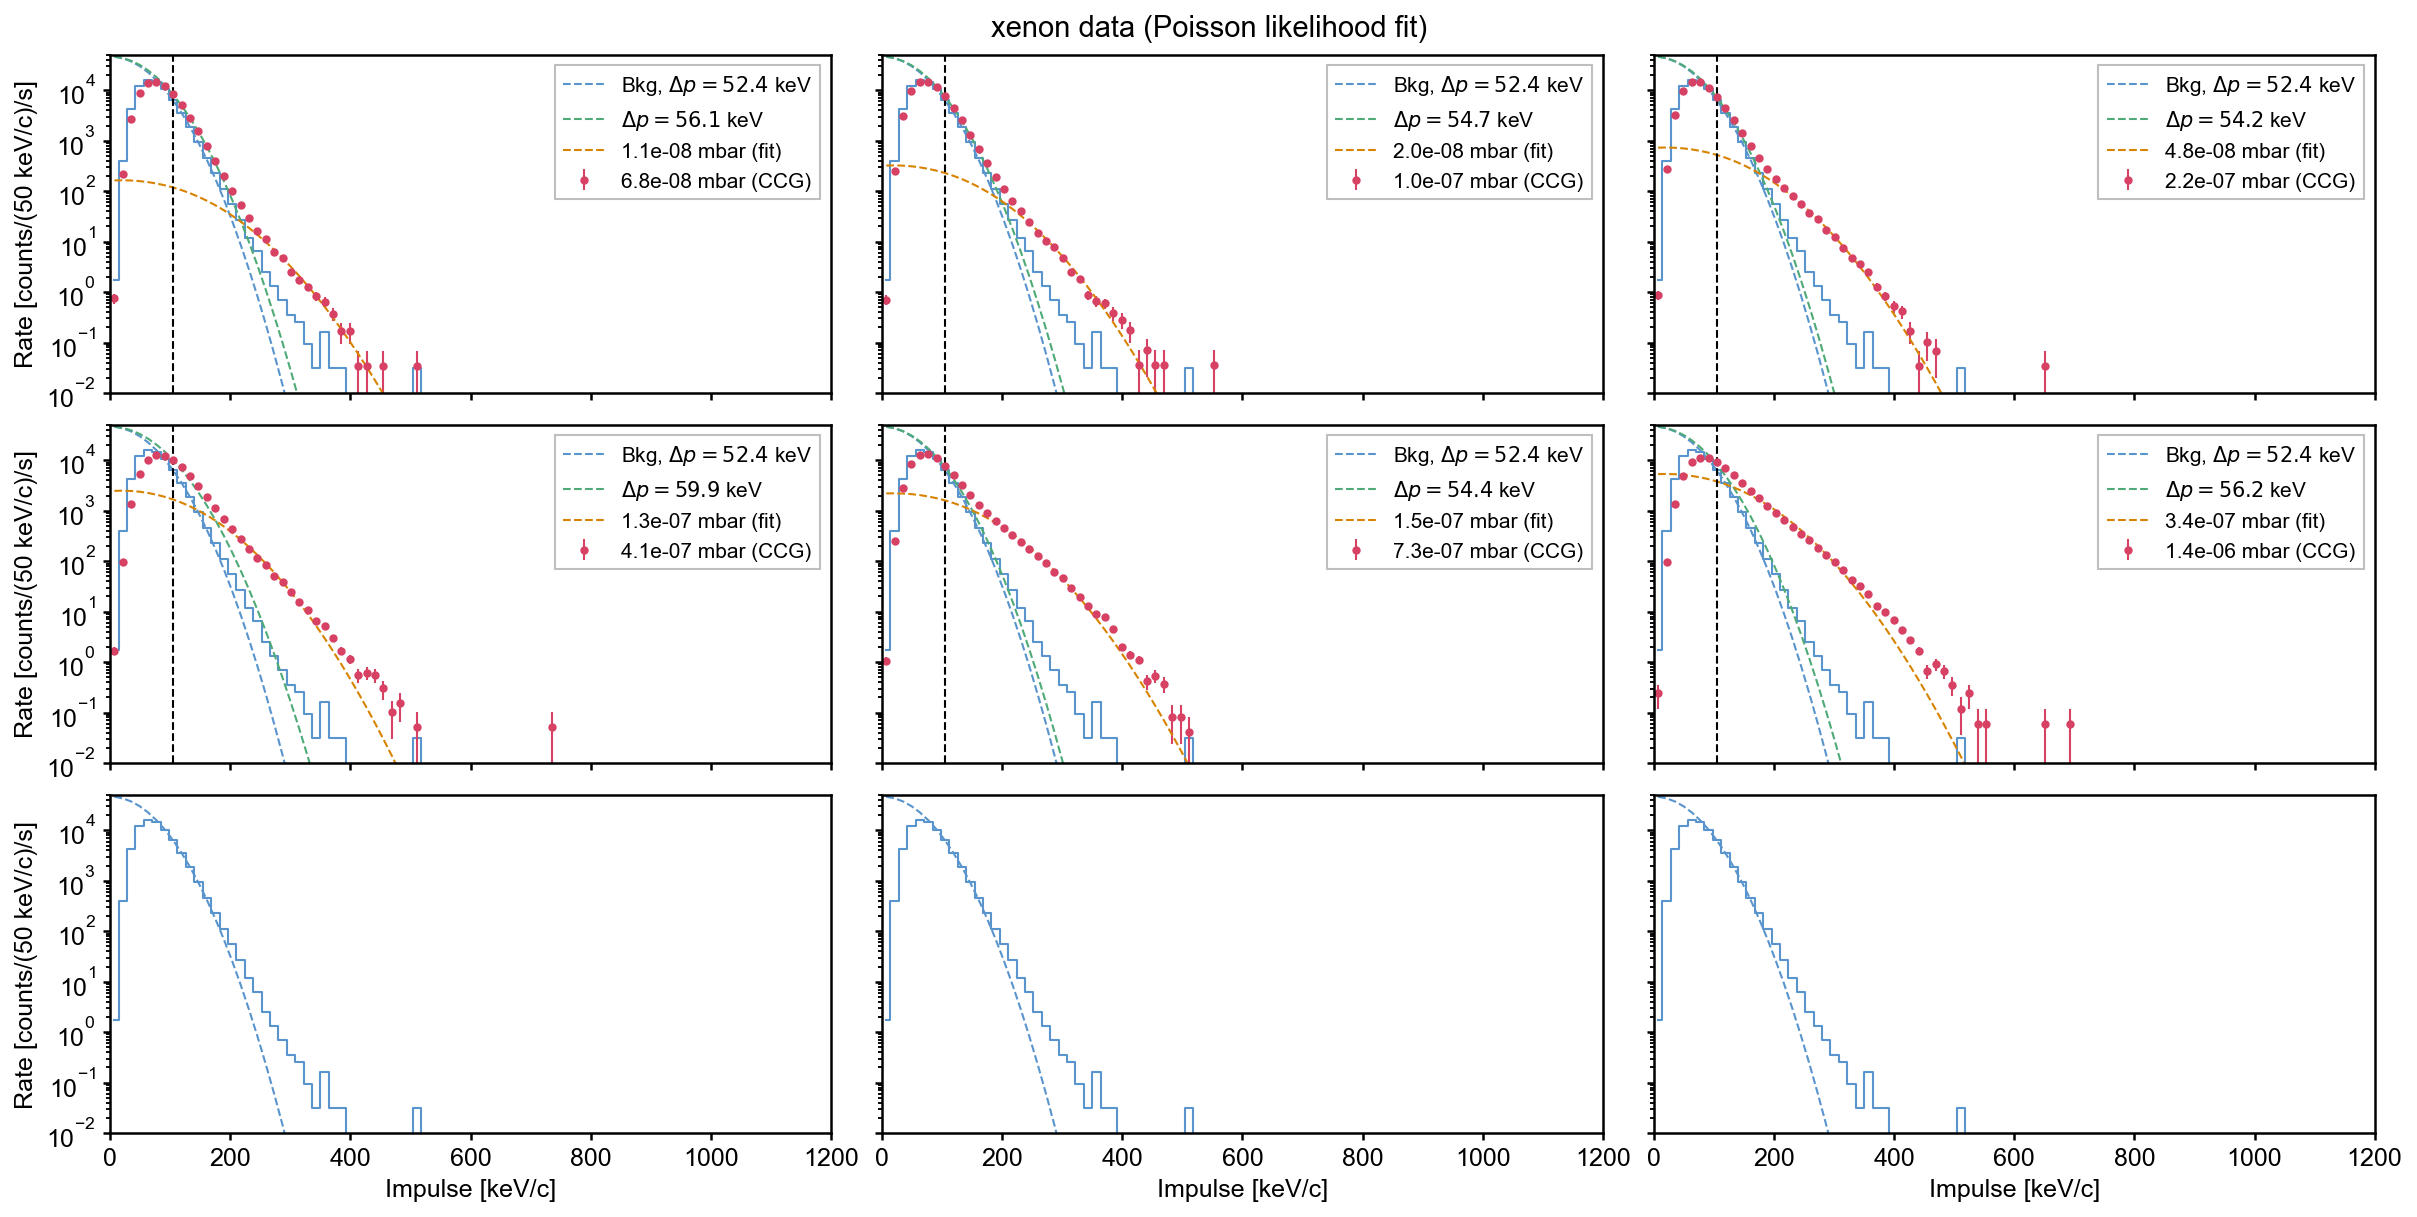

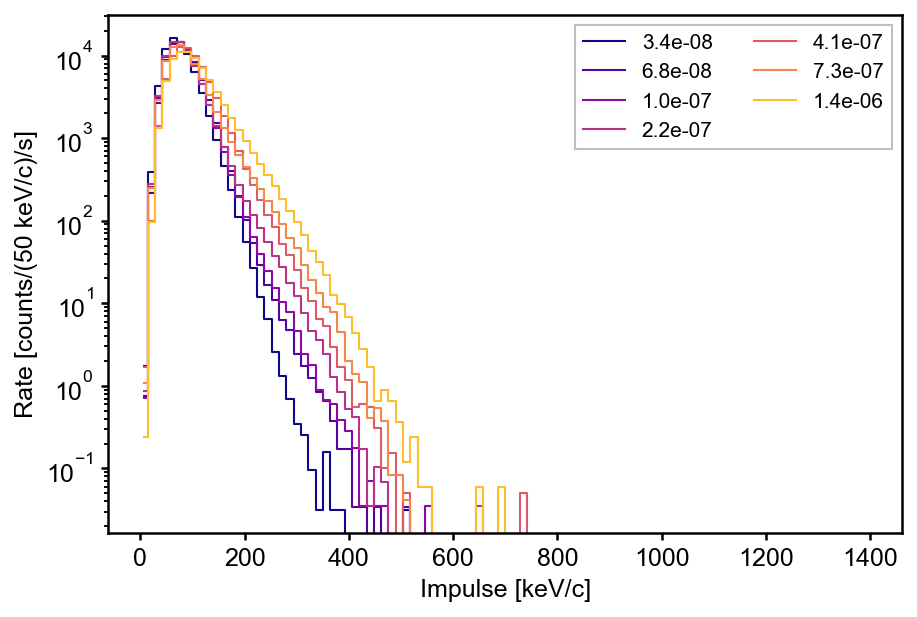

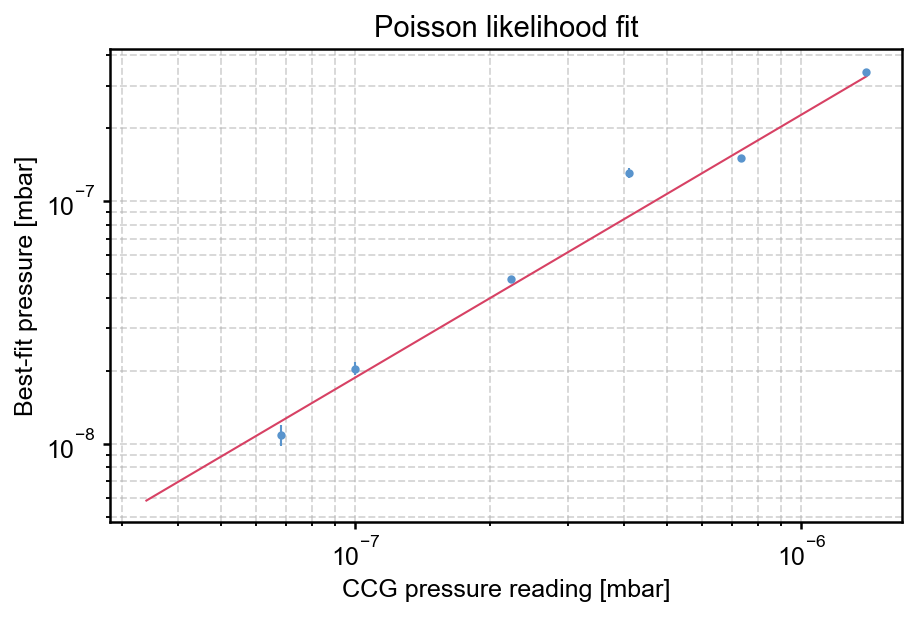

In [89]:
recompute = False

def half_gaus(x, A, sigma):
    return A*np.exp(-x**2/2/sigma**2)#/sigma

def signal_plus_bkg(bins, pressure_mbar, sphere_temperature_K, sigma, alpha):
    # sphere_temperature_K = 800.

    signal_spectrum = gas_collision_spectrum(bins, pressure_mbar, sigma,
                                            temperature_K=sphere_temperature_K,
                                            diameter_nm=config['d_sphere_nm'], 
                                            alpha=alpha, gas=data_type)

    background_spectrum = half_gaus(bins, A_bkg, sigma)

    return signal_spectrum + background_spectrum

def powerlaw(x, a, b):
    return a*x**b

# Refit using proper Poisson negative log-likelihood
# For binned count data, the likelihood is: L = Π_i (μ_i^n_i * e^(-μ_i)) / n_i!
# -ln L = Σ [μ_i - n_i * ln(μ_i)] (dropping constant terms)

class PoissonNLL:
    """Custom Poisson negative log-likelihood cost function for iminuit."""
    
    def __init__(self, bins, counts, scale_factor, model_func):
        self.bins = bins
        self.counts = counts  # Raw counts (not rates)
        self.scale_factor = scale_factor
        self.model_func = model_func
        # Mask for valid bins (exclude zero-count bins to avoid log issues in some cases)
        self.mask = counts >= 0  # Use all bins
        
    def __call__(self, pressure_mbar, sphere_temperature_K, sigma, alpha):
        # Get model prediction in rate units
        model_rate = self.model_func(self.bins[self.mask], pressure_mbar, sphere_temperature_K, sigma, alpha)
        
        # Convert to expected counts
        mu = model_rate / self.scale_factor
        mu = np.maximum(mu, 1e-10)  # Avoid log(0)
        
        n = self.counts[self.mask]
        
        # Poisson NLL: Σ [μ - n*ln(μ)]
        # For bins with n=0, this is just μ
        nll = np.sum(mu - n * np.log(mu))
        
        return nll

fig, axs = plt.subplots(3, 3, figsize=(16, 8), sharex=True, sharey=True, layout='constrained')
fig2, ax2 = plt.subplots(figsize=(6, 4), layout='constrained')
fig3, ax3 = plt.subplots(figsize=(6, 4), layout='constrained')

colors = [plt.get_cmap('plasma', len(datasets) + 1)(i) for i in range(len(datasets))]

ccg_pressures = np.zeros(len(datasets))
fit_pressures = np.zeros(len(datasets))
err_pressures = np.zeros((len(datasets), 2))
fit_temperatures = np.zeros(len(datasets))

for i, nd in enumerate(datasets):

    chi2_mask = build_chi2_mask(nd)
    noise_mask = build_noise_mask(nd, 70)
    det_mask = build_det_mask(nd)
    kick_mask = build_kick_mask(nd, kick_win=1e-5)
    adj_mask = build_adj_mask(nd)
    if i == 0 and recompute:
        interp, levels, pdf = compute_contours(nd)
    contour_mask = build_2d_mask(nd, interp, levels, pdf, num_sigma=1)

    mask = ~kick_mask & contour_mask & det_mask & adj_mask

    bin_edges = np.linspace(0, 1400, 101)

    counts_acc = np.histogram(np.abs(nd.impulses[mask]), bins=bin_edges)[0]

    bins = (bin_edges[1:] + bin_edges[:-1])/2.
    bin_width = bin_edges[1] - bin_edges[0]

    # Compute total observation time
    total_time = len(nd.impulses) * nd.search_window * sum(mask)/len(mask)

    # Scale to rate per 50 keV/c per second
    scale_factor = (50. / bin_width) / total_time
    rate_acc = counts_acc * scale_factor
    err_acc = np.sqrt(counts_acc) * scale_factor

    ax2.step(bins, rate_acc, where='mid', color=colors[i], label='{:.1e}'.format(np.mean(nd.pressures)))

    fit_ind = np.argmin(np.abs(bins - 100))

    if i == 0:
        # Background dataset - fit half-Gaussian
        p_bkg, _ = curve_fit(half_gaus, bins[fit_ind:], rate_acc[fit_ind:], 
                             p0=(rate_acc.max(), np.std(nd.impulses[~np.isnan(nd.impulses)])))
        A_bkg = p_bkg[0]
        noise = p_bkg[1]
        p_fit = [0, 1000., p_bkg[1], 1.]
        p_err = 0
        for j in range(9):
            axs[j % 3, j // 3].step(bins, rate_acc, color='C0', where='mid')
            axs[j % 3, j // 3].plot(bins, signal_plus_bkg(bins, *p_fit), color='C0', ls='--', 
                                                         label='Bkg, $\\Delta p={:.1f}$ keV'.format(noise))
    else:
        # Signal datasets - fit with Poisson NLL
        # Only fit bins above threshold with positive counts
        fit_mask = (bins >= bins[fit_ind])
        counts_fit = counts_acc[fit_mask]
        bins_fit = bins[fit_mask]
        
        # Create Poisson NLL cost function
        poisson_cost = PoissonNLL(bins_fit, counts_fit, scale_factor, signal_plus_bkg)
        
        m = Minuit(poisson_cost, pressure_mbar=np.mean(nd.pressures)/5, sigma=noise, 
                   sphere_temperature_K=300., alpha=1.)
        m.fixed['alpha'] = True
        # m.fixed['sphere_temperature_K'] = True
        # m.fixed['sigma'] = True
        m.limits['pressure_mbar'] = (1e-12, 1e-3)
        m.limits['sphere_temperature_K'] = (100, 3000)
        m.limits['sigma'] = (10, 200)
        m.limits['alpha'] = (0, 1)
        m.errordef = 0.5  # For likelihood fits (not chi2)
        m.simplex().migrad().minos()
        
        print(f"Dataset {i}: P={np.mean(nd.pressures):.1e} mbar (CCG), "
              f"fit P={m.values['pressure_mbar']:.2e}, T={m.values['sphere_temperature_K']:.0f}+/-{m.errors['sphere_temperature_K']:.0f} K, alpha={m.values['alpha']:.2f}, "
              f"valid={m.valid}")
        
        p_fit = np.array(m.values)
        p_err = m.errors['pressure_mbar']

        ax = axs[(i - 1) // 3, (i - 1) % 3]
        rate_plot = rate_acc[rate_acc > 0]
        bins_plot = bins[rate_acc > 0]
        err_plot = err_acc[rate_acc > 0]
        ax.errorbar(bins_plot, rate_plot, yerr=err_plot, ls='none', marker='.', color='C1', 
                    label='{:.1e} mbar (CCG)'.format(np.mean(nd.pressures)))
        # ax.plot(bins, signal_plus_bkg(bins, *p_fit), color='C1', ls='--', 
        #         label='Signal plus background')
        ax.plot(bins, half_gaus(bins, A_bkg, p_fit[2]), color='C2', ls='--', label='$\\Delta p={:.1f}$ keV'.format(p_fit[2]))
        ax.plot(bins, gas_collision_spectrum(bins, m.values['pressure_mbar'], m.values['sigma'], 
                                             m.values['sphere_temperature_K'], diameter_nm=config['d_sphere_nm'],
                                             alpha=m.values['alpha'], gas=data_type), color='C3', ls='--', 
                                             label='{:.1e} mbar (fit)'.format(p_fit[0]))
        ax.set_yscale('log')
        ax.legend(fontsize=10)
        ax.axvline(bins[fit_ind], ls='--', color='k')

    fit_pressures[i] = p_fit[0]
    err_pressures[i] = p_err
    ccg_pressures[i] = np.mean(nd.pressures)
    fit_temperatures[i] = p_fit[1]

axs[0, 0].set_ylim([1e-2, 5e4])
axs[0, 0].set_xlim([0, 1200])
axs[-1, 0].set_xlabel('Impulse [keV/c]')
axs[-1, 1].set_xlabel('Impulse [keV/c]')
axs[-1, 2].set_xlabel('Impulse [keV/c]')
axs[0, 0].set_ylabel('Rate [counts/(50 keV/c)/s]')
axs[1, 0].set_ylabel('Rate [counts/(50 keV/c)/s]')
axs[2, 0].set_ylabel('Rate [counts/(50 keV/c)/s]')
fig.suptitle(data_type + ' data (Poisson likelihood fit)')
fig.savefig(f'figures/{data_type}_panels.png')

ax2.set_yscale('log')
ax2.set_xlabel('Impulse [keV/c]')
ax2.set_ylabel('Rate [counts/(50 keV/c)/s]')
ax2.legend(ncol=2)
fig2.savefig(f'figures/{data_type}_overlaid.png')

p_cal, _ = curve_fit(powerlaw, ccg_pressures[1:], fit_pressures[1:], 
                     sigma=np.mean(err_pressures, axis=1)[1:])

ax3.errorbar(ccg_pressures, fit_pressures, 2*err_pressures.T, marker='.', ls='none')
ax3.plot(ccg_pressures, powerlaw(ccg_pressures, *p_cal))
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlabel('CCG pressure reading [mbar]')
ax3.set_ylabel('Best-fit pressure [mbar]')
ax3.grid(which='both')
ax3.set_title('Poisson likelihood fit')
fig3.savefig(f'figures/{data_type}_calibration.png')

print("\nFit temperatures:")
for i in range(1, len(datasets)):
    print(f"  Dataset {i}: T = {fit_temperatures[i]:.0f} K")

In [90]:
def build_noise_mask(nd, noise_thresh=100, plot=False, plot_2d=False):

    noise_mask = nd.impulse_rms < noise_thresh

    plot_times = nd.pulse_times + np.repeat(nd.timestamps, len(nd.pulse_times)//len(nd.timestamps)) - np.amin(nd.timestamps)

    if plot:
        fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
        ax.semilogy(plot_times, nd.impulse_rms, marker='.', ms=1, alpha=0.1, ls='none')
        ax.axhline(noise_thresh, ls='--', color='C1', label='{:.0f} keV noise cut ({:.1f}% surviving)'\
                                                            .format(noise_thresh, 100*sum(noise_mask)/len(noise_mask)))
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('RMS noise [keV]')
        ax.set_ylim([1e0, 1e4])
        ax.legend(loc='upper right')

    if plot_2d:
        fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
        bins_y = np.linspace(0, 300, 200)
        bins_x = np.linspace(0, 1200, 200)
        h = ax.hist2d(np.abs(nd.impulses), nd.impulse_rms, bins=(bins_x, bins_y), norm='log')
        ax.axhline(noise_thresh, ls='--', color='red', label='{:.0f} keV noise cut'.format(noise_thresh))
        ax.set_xlabel('Impulse [keV/c]')
        ax.set_ylabel('RMS noise [keV]')
        ax.legend(fontsize=10, loc='lower right')
        ax.set_title('RMS noise cut')
        fig.colorbar(h[3], ax=ax, label='Counts', pad=0.01)

    return noise_mask

def build_det_mask(nd, det_cuts=[0.2, 1.2], plot=False):

    det_cuts = np.array(det_cuts)

    det_mask = (nd.cal_facs > det_cuts[0]) & (nd.cal_facs < det_cuts[1])

    plot_times = nd.pulse_times + np.repeat(nd.timestamps, len(nd.pulse_times)//len(nd.timestamps)) - np.amin(nd.timestamps)

    if plot:
        fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
        ax.plot(plot_times, nd.cal_facs, marker='.', ms=1, alpha=0.1, ls='none')
        ax.axhline(det_cuts[0], ls='--', color='C1', label='Detection stability cut ({:.1f}% surviving)'.format(100*sum(det_mask)/len(det_mask)))
        ax.axhline(det_cuts[1], ls='--', color='C1')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Relative calibration factor')
        ax.set_ylim([1e-1, 1e2])
        ax.set_yscale('log')
        ax.legend(loc='upper right')

    return det_mask

def build_kick_mask(nd, kick_win=1e-5):

    file_breaks = np.concat(((0,), np.argwhere(np.diff(nd.deliv_times) < 0)[:, 0]))
    deliv_times = np.copy(nd.deliv_times)

    for i in range(len(file_breaks)):
        if i + 1 >= len(file_breaks):
            deliv_times[file_breaks[i] + 1:] += nd.timestamps[i]
            continue
        deliv_times[file_breaks[i] + 1:file_breaks[i + 1] + 1] += nd.timestamps[i]

    deliv_times[1:] -= np.amin(nd.timestamps)

    plot_times = nd.pulse_times + np.repeat(nd.timestamps, len(nd.pulse_times)//len(nd.timestamps)) - np.amin(nd.timestamps)

    idx = np.searchsorted(deliv_times, plot_times)

    idx0 = np.clip(idx - 1, 0, len(deliv_times) - 1)
    idx1 = np.clip(idx,     0, len(deliv_times) - 1)

    dist0 = np.abs(plot_times - deliv_times[idx0])
    dist1 = np.abs(plot_times - deliv_times[idx1])

    kick_mask = np.minimum(dist0, dist1) < kick_win

    return kick_mask

def build_adj_mask(nd, thresh=300, plot=False):

    inds = np.argwhere(np.abs(nd.impulses) > thresh)[:, 0]
    inds1 = inds[:-1][np.diff(inds) < 2]
    inds2 = inds[1:][np.diff(inds) < 2]
    inds_stacked = np.vstack((inds1, inds2))
    imps_stacked = np.vstack((nd.impulses[inds1], nd.impulses[inds2]))
    adj_mask = np.ones(len(nd.impulses), dtype=bool)
    adj_mask[inds_stacked[np.argmin(np.abs(imps_stacked), axis=0), np.arange(inds_stacked.shape[1])]] = False

    if plot:
        fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
        ax.axvspan(50, 75, alpha=0.2, color='g', ls='--', label='Impulse region')
        ax.axvspan(25, 37, alpha=0.2, color='k', ls='none', label='Noise region')
        ax.axvspan(87, 100, alpha=0.2, color='k', ls='none')
        ax.plot(nd.deconvolved_pulses[inds][:10, :].T)
        ax.set_xlim([0, 124])
        ax.set_xlabel('Time step')
        ax.set_ylabel('Impulse [keV/c]')
        ax.legend()

    return adj_mask

def build_chi2_mask(nd, red_chi2=1.5, plot_2d=False):

    ndof = len(template) - 1
    chi2_mask = np.zeros(nd.chi2.shape, dtype=bool)
    chi2_mask[nd.chi2/ndof < red_chi2] = True

    if plot_2d:
        fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
        bins_y = np.logspace(-1, np.log10(30), 200)
        bins_x = np.linspace(0, 1200, 200)
        h = ax.hist2d(np.abs(nd.impulses), nd.chi2/ndof, bins=(bins_x, bins_y), norm='log')
        ax.axhline(red_chi2, ls='--', color='red', label='Goodness-of-fit cut')
        ax.set_yscale('log')
        ax.set_xlabel('Impulse [keV/c]')
        ax.set_ylabel(r'Reduced $\chi^2$')
        ax.legend(fontsize=10, loc='lower right')
        ax.set_title('Goodness of fit cut')
        fig.colorbar(h[3], ax=ax, label='Counts', pad=0.01)

    return chi2_mask

def compute_contours(nd):

    ndof = len(template) - 1

    x = np.abs(nd.impulse_rms)
    logy = np.log10(nd.chi2/ndof)
    stacked = np.vstack([x, logy])
    kde = stats.gaussian_kde(stacked, bw_method="scott")

    x_min, x_max = 0, 1600
    y_min, y_max = 2e-2, 1e1
    nx, ny = 100, 100

    xc = np.linspace(x_min, x_max, nx)
    yc_log = np.linspace(np.log10(y_min), np.log10(y_max), ny)
    X, YLOG = np.meshgrid(xc, yc_log)

    # Evaluate KDE on the grid
    grid = np.vstack([X.ravel(), YLOG.ravel()])
    Z = kde(grid).reshape(YLOG.shape)

    # Convert KDE to an approximate PDF over the grid for enclosed-probability contours
    dx = xc[1] - xc[0]
    dy = yc_log[1] - yc_log[0]
    pdf = Z * dx * dy

    pdf_flat = pdf.ravel()

    idx = np.argsort(pdf_flat)[::-1]
    cdf = np.cumsum(pdf_flat[idx])

    # Levels corresponding to 68% and 95% enclosed probability (HDR contours)
    levels_pdf = []
    for frac in (0.68, 0.95, 0.997):
        j = min(np.searchsorted(cdf, frac), len(idx) - 1)
        levels_pdf.append(pdf_flat[idx][j])

    interp = RegularGridInterpolator(
        (yc_log, xc), Z,
        method="linear",
        bounds_error=False,
        fill_value=-np.inf,
    )

    return interp, levels_pdf, pdf

def build_2d_mask(nd, interp, levels, pdf, num_sigma=2, plot=False):

    ndof = len(template) - 1

    x = np.abs(nd.impulse_rms)
    logy = np.log10(nd.chi2/ndof)
    stacked = np.vstack([x, logy])
    kde = stats.gaussian_kde(stacked, bw_method="scott")

    x_min, x_max = 0, 1600
    y_min, y_max = 2e-2, 1e1
    nx, ny = 100, 100

    xc = np.linspace(x_min, x_max, nx)
    yc_log = np.linspace(np.log10(y_min), np.log10(y_max), ny)
    X, YLOG = np.meshgrid(xc, yc_log)

    Y = 10**YLOG

    l1, l2, l3 = sorted(levels)
    levels_fill = [l1, l2, l3]

    # x, y are your unbinned data arrays, shape (N,)
    pts = np.column_stack([np.log10(nd.chi2/ndof), nd.impulse_rms])
    mask_inside = interp(pts) >= levels[int(num_sigma) - 1]

    if plot:
        fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
        ax.contour(
            X, Y, pdf,
            levels=levels_fill,
            colors='red',
            linestyles='--'
        )
        bins_y = np.logspace(-1, 1, 200)
        bins_x = np.linspace(0, 300, 200)
        h = ax.hist2d(nd.impulse_rms, nd.chi2/ndof, bins=(bins_x, bins_y), norm='log')
        # ax.axhline(chi2_cut, ls='--', color='red', label='Goodness-of-fit cut')
        # ax.axvline(noise_thresh, ls='--', color='blue', label='{:.0f} keV noise cut'.format(noise_thresh))
        ax.set_yscale('log')
        ax.set_xlabel('RMS noise [keV/c]')
        ax.set_ylabel(r'Reduced $\chi^2$')
        # ax.legend(fontsize=10, loc='lower right')
        ax.set_title(r'2D noise and $\chi^2$ cut')
        fig.colorbar(h[3], ax=ax, label='Counts', pad=0.01)

    return mask_inside